# Cross-resonance gate between a transmon and a fluxonium

In this tutorial notebook we study the cross-resonance two-qubit gate between a transmon and a fluxonium. 

In [46]:
import numpy as np
import scipy.integrate
import time
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pysqkit
from pysqkit import QubitSystem, Qubit
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, \
    average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
import pysqkit.util.transformations as trf
from pysqkit.util.linalg import get_mat_elem
from pysqkit.solvers.solvkit import integrate
from pysqkit.util.hsbasis import pauli_by_index
from pysqkit.solvers import solvkit
from pysqkit.drives.pulse_shapes import gaussian_top
from typing import List, Dict, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import copy
import json
import cmath
import util_tf_cr

from IPython.display import display, Latex

The gate is based on the following driven Hamiltonian of a fluxonium and a transmon capacitively coupled

$$H = H^{(0)}_t + H^{(0)}_f + V + H_{drive},$$

$$H^{(0)}_T =  \hbar \omega_t b^{\dagger}b + \hbar \frac{\delta_t}{2} b^{\dagger} b^{\dagger}b b,$$

$$H^{(0)}_f = 4 E_{C,f} q_f^2 + \frac{1}{2}E_{L,f}\phi_f^2 - E_{J,f}\cos\left(\phi_f - \phi_{ext,f}\right),$$


$$V = J_C q_t q_f,$$

$$H_{drive} = \hbar g(t) \varepsilon_d \cos(2\pi f_d t) q_f  ,$$

with $$g(t) \in [0, 1], \, \forall t$$ an envelope function.

The (approximate) charge operator for the transmon in terms of annihilation and creation operators reads

$$q_t = i \biggl( \frac{E_J}{32 |\delta_T |} \biggr)^{1/4} (b^{\dagger} - b),$$
where 
$$
E_{J, t} = \frac{\hbar  (\omega_t - \delta_t)^2}{8 | \delta_t |}.
$$

In the following we also consider the case in which we have relaxation due to dielectric loss.

The idea behind the cross-resonance gate is to drive one of the qubit at the frequency of the other using the fact that due to the coupling we have a $Z Y$ (or $ZX$ depending on the phase of the drive) term in the Hamiltonian. In particular, we will explore the idea of driving the fluxonium at the transmon frequency. The opposite idea to drive the transmon at the fluxonium frequency leads to much smaller gate times.

# Introducing the qubits and the coupled system

In [47]:
with open('flx_transm_params.txt') as param_file:
    parameters_set = json.load(param_file)

In [48]:
temperature = 0.020 #0.020 # K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz
d_comp = 4

p_set = "CR_UMA5" # This parameter set corresponds to omega_t/2 \pi = 4.7

# Other parameter set ['CR_1', 'CR_3', 'CR_4'] corresponding to 
# omega_t/2 \pi = 4.3, 5.3, 5.7 respectively.


#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq=parameters_set[p_set]["max_freq_t"], 
    anharm=parameters_set[p_set]["anharm_t"],
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_t"],
    env_thermal_energy=thermal_energy,    
    dim_hilbert=levels_t,
    dephasing_times=None
)

#Fluxonium
# In this tutorial we include 5 levels, but more levels should be included
# to capture transitions to higher levels
levels_f = 5

flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=parameters_set[p_set]["charge_energy_f"], 
    induct_energy=parameters_set[p_set]["induct_energy_f"], 
    joseph_energy=parameters_set[p_set]["joseph_energy_f"],  
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_f"], 
    env_thermal_energy=thermal_energy,
    dephasing_times=None
)
flx.diagonalize_basis(levels_f)

# We add the drive on the fluxonium
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cr_drive_f',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

d_leak = levels_t*levels_f - d_comp

jc = parameters_set[p_set]["jc"]
coupled_sys = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
bare_system = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0.0)

states_label = coupled_sys.all_state_labels()
states_dict = coupled_sys.states_as_dict(as_qobj=True)
flx_freq = flx.eig_energies(2)[1] - flx.eig_energies(2)[0]
flx_freq_03 = flx.eig_energies(4)[3] - flx.eig_energies(4)[0]
flx_freq_12 = flx.eig_energies(4)[2] - flx.eig_energies(4)[1]

In [49]:
state_label = ["00", "01", "10", "11"]
comp_states = {}
for label in state_label:
    state_tmp = coupled_sys.state(label)[1]
    loc = np.argmax(np.abs(state_tmp))
    phase = cmath.phase(state_tmp[loc])
    state_tmp = np.exp(-1j*phase)*state_tmp
    comp_states[label] = state_tmp

The basis principle behind the gate is illustrated in the following figure

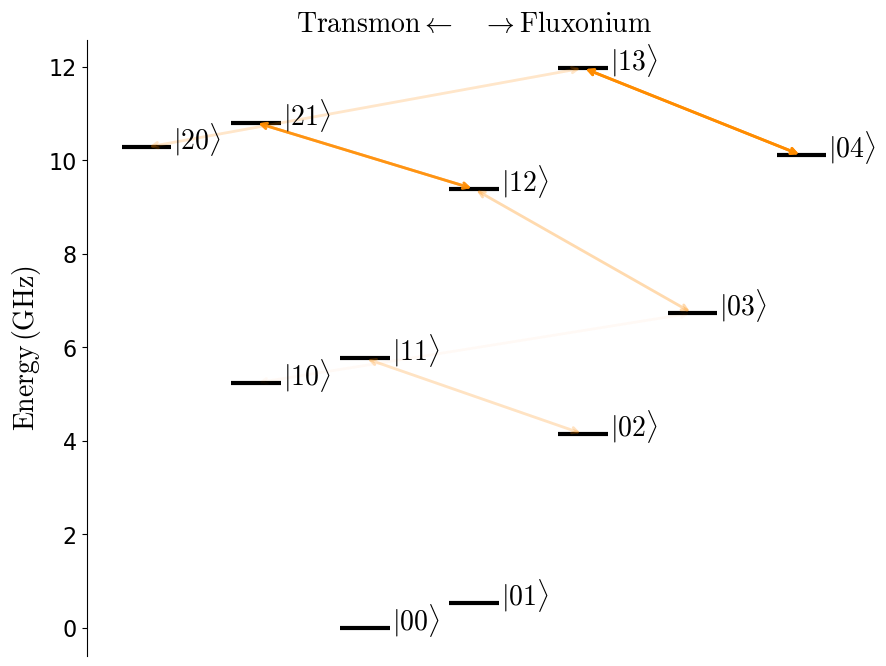

In [50]:
level_list = ['00', '01', '10', '11', '02', '20', '12','21', '03', '13', '04']

util_tf_cr.energy_levels_diagram(bare_system, level_list, show_drive=False)

The figure shows the energy of the bare levels. The orange arrows indicate the non-zero matrix elements between the (bare) levels provided by the capacitive coupling $V$: the more shaded the arrow the weaker the coupling. 
We look at the following quantities : 

$$\zeta_{ZZ}/2 \pi = (E_{00} + E_{11} - E_{01} - E_{10})/h$$
$$\mu_{YZ} = (\lvert \langle 10 | q_{F} | 00 \rangle - \langle 11 | q_{F} |01 \rangle \rvert )\varepsilon_d/2 $$
$$\mu_{Y} = (\lvert \langle 10 | q_{F} | 00 \rangle + \langle 11 | q_{F} |01 \rangle \rvert) \varepsilon_d/2 $$

The second term quantifies the gate speed. Notice that if the phase of the drive is $0$ one has a $YZ$ term from the charge operator. 

For the given parameters we have

In [51]:
# The following functions can also be found in the util_tf_cr.py file and are here reported for clarity
# of the notebook

def zz(system: QubitSystem) -> float:
    xi_zz = system.state('00')[0] + system.state('11')[0] \
        - system.state('01')[0] - system.state('10')[0]
    return xi_zz

def mu_yz_flx(
    comp_states: List[np.ndarray], 
    op: np.ndarray,
    eps: float
) -> float:
    """
    Description
    ---------------------------------------------------------------------------
    Evaluates the CR coefficient numerically in the dressed basis when
    driving the fluxonium
    """
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 - yz1))/2*eps/2

def mu_zy_transm(
    comp_states: List[np.ndarray], 
    op: np.ndarray,
    eps: float
) -> float:
    """
    Description
    ---------------------------------------------------------------------------
    Evaluates the CR coefficient numerically in the dressed basis when
    driving the transmon
    """
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['01'])
    yz1 = get_mat_elem(op, comp_states['10'], comp_states['11'] )
    return (np.imag(yz0 - yz1))/2

def mu_yi_flx(
    comp_states: List[np.ndarray], 
    op: np.ndarray,
    eps: float
) -> float:
    """
    Description
    ---------------------------------------------------------------------------
    Evaluates the direct drive on the transmon numerically in the dressed basis 
    when driving the fluxonium
    """
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'] )
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 + yz1))/2*eps/2

def mu_yz_flx_sw(
    transm: Qubit,
    flx: Qubit,
    jc: float,
    eps: float
):
    """
    Description
    ---------------------------------------------------------------------------
    Evaluates the CR coefficient via the second order Schrieffer-Wolff
    transformation
    """
    q_zpf = transm.charge_zpf
    omega_t = transm.freq
    omega_flx, states_flx = flx.eig_states(4)
    omega_flx = omega_flx - omega_flx[0]
    q_10 = np.imag(get_mat_elem(flx.charge_op(), states_flx[1], states_flx[0]))
    q_21 = np.imag(get_mat_elem(flx.charge_op(), states_flx[2], states_flx[1]))
    q_30 = np.imag(get_mat_elem(flx.charge_op(), states_flx[3], states_flx[0]))
    coeff = q_21**2/(omega_flx[2] - (omega_t + omega_flx[1]))
    coeff += -q_30**2/(omega_flx[3] - omega_t)
    coeff += q_10**2/(omega_t - omega_flx[1]) 
    mu_yz = jc*q_zpf*coeff/2*eps/2
    return mu_yz

In [52]:
# Example
eps_test = 0.3
display(Latex(r'$f_{{flx}} = {:.3f} \, \mathrm{{MHz}}$'.format(flx_freq*1e3)))
display(Latex(r'$\xi_{{ZZ}}/2 \pi = {:.3f} \, \mathrm{{MHz}}$'.format(1e3*zz(coupled_sys))))
q_op = coupled_sys["F"].charge_op()
display(Latex(r'$\mu_{{YZ}}/2 \pi = {:.4f} \, \mathrm{{MHz}}$'.format(mu_yz_flx(comp_states, q_op, eps_test*1e3))))
display(Latex(r'$\mu_{{YZ}}^{{(SW)}}/2\pi = {:.4f} \, \mathrm{{MHz}}$'.format(mu_yz_flx_sw(transm, flx, jc, eps_test*1e3))))
display(Latex(r'$\mu_{{YI}}/2\pi = {:.4f} \, \mathrm{{MHz}}$'.format(mu_yi_flx(comp_states, q_op, eps_test*1e3))))
display(Latex(r'$\mu_{{ZY}}/2\pi = {:.6f} \, \mathrm{{MHz}}$'.format(mu_zy_transm(comp_states, q_op, eps_test*1e3))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In what follows we take the phase of the drive to be $0$ and so we get a $ZY$ term. If we set it $\pi/2$ we get a
$ZX$ term and so we should simply make the substitution $Y \mapsto X$. 

The aim of the cross-resonance gate is to realize the following unitary
$$
\mathrm{CR}_{\theta} = e^{-i \frac{\theta}{2} Y \otimes Z } = \cos\biggl(\frac{\theta}{2} \biggr) I -i \sin\biggl(\frac{\theta}{2} \biggr) Y \otimes Z
$$

In particular it is known that $\mathrm{CR}_{-\pi/2}$ is equivalent to a CNOT up to single-qubit gates.

In [53]:
def func_to_minimize(
    pulse_time: list,
    t_rise: float,
    cr_coeff: float
) -> float:
    """
    Description
    --------------------------------------------------------------
    Computes the difference between the time integral 
    of the CR coefficient and the target phase \pi/4.
    """
    step = 1e-3
    n_points = int(pulse_time[0]/step)
    times = np.linspace(0, pulse_time[0], n_points)
    pulse = gaussian_top(times, t_rise, pulse_time[0])
    integral = scipy.integrate.simpson(2*np.pi*cr_coeff*pulse, times)
    return np.abs(integral - np.pi/4)  
    

In [55]:
eps = 0.5
omega_flx, states_flx = flx.eig_states(4)
op = coupled_sys["F"].charge_op()
freq_drive = transm.max_freq
omega_drive = np.abs(get_mat_elem(op, coupled_sys.state("01")[1], coupled_sys.state("11")[1]))
delta_drive = freq_drive - transm.max_freq
rabi_period = 1/np.sqrt(omega_drive**2 + delta_drive**2)
t_rise = 10.0 # [ns]

# Here we can choose either to pass the numerical CR coefficient
# or the one obtained from the Schrieffer-Wolff formula. As the SW formula
# is approximate and does not include the effect of higher levels we find
# that the numerical coefficient leads to more accurate gate times that
# give higher fidelity.

cr_coeff = np.abs(util_tf_cr.mu_yz_flx(comp_states, op, eps))

t_gate_0 = [util_tf_cr.cr_gate_time(cr_coeff)]

args_to_pass = (t_rise, cr_coeff) 

start = time.time()

minimization_result = minimize(func_to_minimize, t_gate_0, args=args_to_pass)

print(minimization_result)

end = time.time()

t_gate = minimization_result['x'][0] 
print("t_gate: {} ns".format(t_gate))
pts_per_drive_period = 10

nb_points = int(t_gate*freq_drive*pts_per_drive_period)
tlist = np.linspace(0, t_gate, nb_points)

coupled_sys['F'].drives['cr_drive_f'].set_params(phase=0, time=tlist, rise_time=t_rise, pulse_time=t_gate,
                                                 amp=eps, freq=freq_drive)


      fun: 9.351297514115231e-12
 hess_inv: array([[988.96127015]])
      jac: array([0.00472102])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 102
      nit: 1
     njev: 45
   status: 2
  success: False
        x: array([142.00188754])
t_gate: 142.00188754287132 ns


We introduce the TomoEnv object. We also refine the absolute and relative tolerance of the qutip solver.

In [56]:
simu_opt = qtp.solver.Options()
simu_opt.atol = 1e-14
simu_opt.rtol = 1e-12

# set with_noise to True to simulate the noisy case

env_syst = pysqkit.tomography.TomoEnv(system=coupled_sys, time=2*np.pi*tlist, options=simu_opt, 
                                      with_noise=False, dressed_noise=False)

The TomoEnv class can return the Hilbert-Schmidt representation of the quantum operation in an arbitrary Hilbert-Schmidt basis for a $d$-dimensional subspace, as long as this is a basis of diagonalizable operators. For instance the basis $|n \rangle \langle m|$, $n, m= 0, \dots, d-1$ is not a diagonalizable basis and thus the method cannot be used. 

In what follows we are interested in obtaining a superoperator representation of a quantum operation in the computational subspace that we here define

In [57]:
comp_states_list = []
for key in comp_states.keys():
    comp_states_list.append(comp_states[key])

Notice that the choice of how to define the computational subspace is left to the user. In our case we take the "dressed" levels $|00 \rangle, |01 \rangle, |10 \rangle, |11 \rangle$ as explained in the paper.

In [58]:
# We use the "dressed" Pauli basis, i.e., we get the Pauli transfer matrix

n_process = 4

my_hs_basis = pauli_by_index

start = time.time()
sup_op = env_syst.to_super(comp_states_list, my_hs_basis, n_process, speed_up=True)
end = time.time()
print("Computational time = " + str(end - start) + ' s')

Computational time = 29.345671892166138 s


Notice how the superoperator can be obtained for any system and its operations are completely system agnostic.

We now use the previous superoperator to compute the process fidelity and average gate fidelity with respect to a $\mathrm{CR}$ gate. First of all, we need to obtain the single-qubit $Z$ corrections (simulations are done in the Schrödinger picture without any rotating wave approximation). This can be done directly from the superoperator via the following function.

In [59]:
sq_corr = util_tf_cr.single_qubit_corrections(sup_op, my_hs_basis)
sq_corr_sup = trf.kraus_to_super(sq_corr, my_hs_basis)
total_sup_op = sq_corr_sup.dot(sup_op)

We now compute the process fidelity. In order to do this we first need to obtain the superoperator representation of the $\mathrm{CR}$ in our chose Hilbert-Schmidt basis. This can be done via the function qutip.util.transformations.kraus_to_super

In [60]:
def cry(theta):
    ide = np.identity(4)
    yz = np.kron(np.array([[0, -1j], [1j, 0]]), np.array([[1, 0], [0, -1]]))
    return np.cos(theta/2)*ide - 1j*np.sin(theta/2)*yz

def crx(theta):
    ide = np.identity(4)
    zx = np.kron(np.array([[0, 1], [1, 0]]), np.array([[1, 0], [0, -1]]))
    return np.cos(theta/2)*ide - 1j*np.sin(theta/2)*zx

We can now compute the process fidelity

In [61]:
cr_super_target = trf.kraus_to_super(cry(-np.pi/2), my_hs_basis)
f_pro = average_process_fidelity(cr_super_target, total_sup_op)
display(Latex(r'$F_{{pro}} = {:.5f}$'.format(f_pro)))

<IPython.core.display.Latex object>

Notice that this is by choice not done within the TomoEnv class, since the TomoEnv class should be agnostic of which gate we want to implement. Since during the gate also an unwanted $Y$ rotations is implemented let us try to virtually correct it. In particular, we look for the $Y$ rotation on the transmon that maximized the fidelity.

In [62]:
def ry_t(theta):
    rot_y = np.cos(theta/2)*np.identity(2) - 1j*np.sin(theta/2)*np.array([[0, -1j], [1j, 0]])
    return np.kron(rot_y, np.identity(2))

def ry_f(theta):
    rot_y = np.cos(theta/2)*np.identity(2) - 1j*np.sin(theta/2)*np.array([[0, -1j], [1j, 0]])
    return np.kron(np.identity(2), rot_y)

We now look for the single-qubit $Y$ correction on the transmon that maximizes the fidelity.

In [63]:
theta_list = list(np.linspace(0, 2*np.pi, 100))
fid_list_ry = []
for theta in theta_list:
    rot_y_super = trf.kraus_to_super(ry_t(theta), my_hs_basis)
    fid_list_ry.append(average_process_fidelity(cr_super_target, rot_y_super.dot(total_sup_op)))

fid_ry = np.array(fid_list_ry)
max_fid = np.max(fid_ry)
max_index = np.argmax(fid_ry)
sup_rot_y_opt = trf.kraus_to_super(ry_t(theta_list[max_index]), my_hs_basis)
display(Latex(r"Maximum achievable fidelity after ideal $Y$ rotations = ${}$".format(max_fid)))

<IPython.core.display.Latex object>

The average leakage and seepage is computed within the TomoEnv class. This is because we just need to specify a subspace to determine them, similarly to the determination of the superoperator. We use Eq. 2 and 3 in Wood-Gambetta Phys. Rev. A 97, 032306 (2018) to calculate the average leakage and seepage respectively. 

In [64]:
avg_leakage = env_syst.leakage(comp_states_list)
display(Latex(r'$L_1(\mathcal{{E}} ) = {:.7f}$'.format(avg_leakage)))

<IPython.core.display.Latex object>

We observe that leakage is sensitive to whether we have a smooth rise time or not...

In [65]:
avg_seepage = env_syst.seepage(comp_states_list)
display(Latex(r'$L_2(\mathcal{{E}} ) = {:.7f}$'.format(avg_seepage)))

<IPython.core.display.Latex object>

We can also check that, with the selected accuracy of the qutip solver, for unitary dynamics (set loss tangents equal to zero) we reproduce the relation between leakage and seepage $d_1 L_1(\mathcal{E}) = d_2 L_2(\mathcal{E})$ ($d_1=4, d_2 = 11$)

In [66]:
display(Latex(r'$d_1 L_1(\mathcal{{E}} ) = {:.7f}$'.format(d_comp*avg_leakage)))

<IPython.core.display.Latex object>

In [67]:
display(Latex(r'$d_2 L_2(\mathcal{{E}} ) = {:.7f}$'.format(d_leak*avg_seepage)))

<IPython.core.display.Latex object>

Notice that $d_1 L_1 = d_2 L_2$ is only true in the noiseless case.

Finally, the average gate fidelity is

In [68]:
total_sup_op_ry = sup_rot_y_opt.dot(total_sup_op)
f_gate = average_gate_fidelity(cr_super_target, total_sup_op_ry, avg_leakage)
display(Latex(r'$F_{{gate}} = {:.5f}$'.format(f_gate)))


<IPython.core.display.Latex object>